<a href="https://colab.research.google.com/github/omarFarooq21/Miscellanous/blob/main/DL4NLP_Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **HOMEWORK 2**

*   **Run following cells to mount drive and import all necessary dependencies**

In [ ]:
# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

# path to store the data
%cd /content/drive/MyDrive/Colab Files/DL4NLP

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Files/DL4NLP


In [ ]:
# Import Dependencies

!pip install datasets
from datasets import load_dataset

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import numpy as np

from tqdm import tqdm
from nltk import word_tokenize
import nltk
nltk.download('punkt')

from scipy.stats import pearsonr, kendalltau

from pprint import pprint

import matplotlib.pyplot as plt

import gdown

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# Specify random seed
def seed_everything(seed: int):
    import random, os
    import numpy as np
    import torch

    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

# **Task 1: Getting to Know Pytorch: Semantic Textual Similarity**

In this task, we define semantic textual similarity (STS) as a supervised regression task in which the semantic similarity of two pieces of text (typically sentences) should be determined.

### **Task 1.1: Data Preparation**

First we should load the dataset for this task. Each entry of this dataset contains one English sentence pair and their similarity score. The data is structured like both Python dictionary and Pandas DataFrame.
*   **Run the following cell to load the dataset:**


In [ ]:
train_set = load_dataset("stsb_multi_mt", "en", split='train')
dev_set = load_dataset("stsb_multi_mt", "en", split='dev')

dev_set

Dataset({
    features: ['sentence1', 'sentence2', 'similarity_score'],
    num_rows: 1500
})

**a)** To get familiar with the data format, print following information:
*  **The first entry of `train_set`**
*  **the size of `dev_set`**
*  **the first 3 `sentence1` in `train_set`**


In [ ]:
# TODO: YOUR CODE HERE
print(f'###The first entry of \'trainset\':\n {train_set[0]}')
print(f'###The size of \'dev_set\':\n {dev_set.shape}')
print(f'###The first 3 \'sentence1\' in \'train_set\': \n {train_set[0:3]}')
train_set.shape

###The first entry of 'trainset':
 {'sentence1': 'A plane is taking off.', 'sentence2': 'An air plane is taking off.', 'similarity_score': 5.0}
###The size of 'dev_set':
 (1500, 3)
###The first 3 'sentence1' in 'train_set': 
 {'sentence1': ['A plane is taking off.', 'A man is playing a large flute.', 'A man is spreading shreded cheese on a pizza.'], 'sentence2': ['An air plane is taking off.', 'A man is playing a flute.', 'A man is spreading shredded cheese on an uncooked pizza.'], 'similarity_score': [5.0, 3.799999952316284, 3.799999952316284]}


(5749, 3)

In [ ]:
train_set[:3]


{'sentence1': ['A plane is taking off.',
  'A man is playing a large flute.',
  'A man is spreading shreded cheese on a pizza.'],
 'sentence2': ['An air plane is taking off.',
  'A man is playing a flute.',
  'A man is spreading shredded cheese on an uncooked pizza.'],
 'similarity_score': [5.0, 3.799999952316284, 3.799999952316284]}

## **Task 1.1.1: Sentence Embedding with FastText**
We will use the averages of the words using [FastText embeddings](https://fasttext.cc/docs/en/english-vectors.html) to embed both sentences.

* **Run the following cell to download the embeddings.**

In [ ]:
# download word emebddings to your drive and unzip the file (run this cell only when you haven't downloaded the emb file yet.)
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip
!unzip wiki-news-300d-1M.vec.zip

--2024-06-05 13:17:11--  https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.173.166.51, 18.173.166.31, 18.173.166.48, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.173.166.51|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 681808098 (650M) [application/zip]
Saving to: ‘wiki-news-300d-1M.vec.zip.2’

wiki-news-300d-1M.v 100%[===================>] 650.22M  55.1MB/s    in 13s     

2024-06-05 13:17:24 (49.7 MB/s) - ‘wiki-news-300d-1M.vec.zip.2’ saved [681808098/681808098]

Archive:  wiki-news-300d-1M.vec.zip
replace wiki-news-300d-1M.vec? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

**b)**    **Implement the function** `load _embeddings` to read the word embeddings into a Python dictionary that maps every token to the corresponding vector and returns word embeddings. Represent the vectors as Numpy arrays. Only load the embeddings of the first 30,000 tokens in the file

In [ ]:
def load_embeddings(file="wiki-news-300d-1M.vec"):
  # TODO: YOUR CODE HERE
  dictionary = {}
  fin = open(file, 'r', encoding='utf-8', newline='\n', errors='ignore')
  dimensionality = fin.readline().split(' ')
  print(f'Number of words: {dimensionality[0]}. Number of word vecs: {dimensionality[1]}')
  count = 30000
  i=0
  for each_line in fin:
    tokens = each_line.rstrip().split(' ')
    #print(tokens[0], tokens[1], tokens[300])
    dictionary[tokens[0]] = np.array(list(map(float, tokens[1:])))
    i+=1
    if(i == count):
      break
  #print(dictionary.get(','))
  return dictionary

dict = load_embeddings()

Number of words: 999994. Number of word vecs: 300




**c)**   **Print** the size of the dictionary and the first 10 dimensions of the embedding for the word "Frequency".

In [ ]:
# TODO: YOUR CODE HERE
print(f'# length of dictionary: ', len(dict))
embedding = dict.get('Frequency')
print(f'## First 10 dimensions of the embedding for the word \'Freqeuncy\':\n {embedding[:10]}')

# length of dictionary:  30000
## First 10 dimensions of the embedding for the word 'Freqeuncy':
 [-0.1752  0.0877  0.0047  0.0691 -0.0453 -0.2031 -0.2423  0.1085  0.092
  0.1646]



**d)**  **Implement a function** `tokenize` that tokenizes a sentence using nltk.word_tokenize and returns a list of tokens for given sentence.



In [ ]:
def tokenize(sentence):
  # TODO: YOUR CODE HERE
  tokens = word_tokenize(sentence)
  return tokens

tokenized = tokenize("Hello, World!")
print(tokenized)
comma = dict.get(',')
comma[:10]

['Hello', ',', 'World', '!']


array([ 0.1073,  0.0089,  0.0006,  0.0055, -0.0646, -0.06  ,  0.045 ,
       -0.0133, -0.0357,  0.043 ])

**e)**  **Print** the tokenized `sentence1` and `sentence2` of the 20th entry in the training set.

In [ ]:
# TODO: YOUR CODE HERE
sentence1, sentence2, simscore= train_set[20]
sentence1 = train_set[20].get(sentence1)
sentence2 = train_set[20].get(sentence2)

print(f'Tokenized sentence 1: {tokenize(sentence1)}')
print(f'Tokenized sentence 2: {tokenize(sentence2)}')

Tokenized sentence 1: ['A', 'man', 'pours', 'oil', 'into', 'a', 'pot', '.']
Tokenized sentence 2: ['A', 'man', 'pours', 'wine', 'in', 'a', 'pot', '.']


**f)** **Implement a function** `embed_sentence` that maps a sentence to its embedding. The sentence-level embedding should be the average of the embeddings of its tokens. If a token does not exist in the vocabulary of FastText, embed this token as a 0-vector with the same dimensions as the FastText embeddings.


In [ ]:
def embed_sentence(sentence, word2emb):
  # TODO: YOUR CODE HERE
  sentence_embedding = np.zeros(300)
  tokens = tokenize(sentence)
  total_words = 0
  for i, word in enumerate(tokens):
    embeddings = word2emb.get(word)
    if embeddings is not None:
      sentence_embedding += embeddings
    else:
      embeddings = np.zeros(300)
      sentence_embedding += embeddings
    total_words += 1

  if total_words > 0:
    sentence_embedding /= total_words
  return sentence_embedding

**g)**  **Print** the shape and the first 10 dimensions of `sentence1`'s embedding of the 20th entry in the training set.

In [ ]:
# TODO: YOUR CODE HERE

print(sentence1)
embedding_tensor = embed_sentence(sentence1, dict)
embedding_tensor[:10]

A man pours oil into a pot.


array([-0.03605  , -0.0061875,  0.0339   , -0.0033625, -0.0274375,
       -0.0258125,  0.0595   , -0.039825 , -0.06175  , -0.037025 ])

## **Task 1.1.2: Build Custom Dataset**


* **Implement a custom dataset class** `MLPDataset` inheriting `torch.utils.data.Dataset` and override the following methods:
  1.   `__len__`: which returns the size of the dataset.
  2.   `__getitem__`: to support the indexing such that dataset[i] can be used to get ith sample.
  
      The ith sample should be a Python dict with two entries:
    * ` encoding`: the encoding of one sentence pair, which is the concatenation of the embeddings of the two sentences of a pair. E.g., sent1 = [1,2], sent2 = [3,4], the encoding for sent1 and sent2 should be [1,2,3,4].
    *   `score `: the similarity score between the two sentences.
Hint: examples can be found here: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html





In [ ]:
## Encodes each sentence into a single 300 dimension vector
class MLPDataset(Dataset):
  def __init__(self, sents_1, sents_2, scores, word2emb):
    """
    Arguments:
      sents_1 (List[string]): the list of the first sentences.
      sents_2 (List[string]): the list of the second sentences.
      scores (List[float]): the list of the similarity scores.
    """
    # TODO: YOUR CODE HERE
    self.sents_1 = sents_1
    self.sents_2 = sents_2
    self.scores = scores
    self.word2emb = word2emb


  def __getitem__(self, idx):
    # TODO: YOUR CODE HERE
    # np.concatenate(self.sents_1[idx],self.sents_2[idx])
    # score = self.scores[idx]
    embedding_tensor_1 = embed_sentence(self.sents_1[idx], self.word2emb).astype(np.float32)
    embedding_tensor_2 = embed_sentence(self.sents_2[idx], self.word2emb).astype(np.float32)

    sample = {'encoding': torch.tensor(np.concatenate((embedding_tensor_1, embedding_tensor_2))),
              'score': torch.tensor(np.array(self.scores[idx], dtype=np.float32))}
    return sample


  def __len__(self):
    # TODO: YOUR CODE HERE
    return len(self.sents_1)


**h)**  **Instantiate** the above class for our `train_set` and `dev_set`.

In [ ]:
# TODO: YOUR CODE HERE
sents_1 = train_set['sentence1']
sents_2 = train_set['sentence2']
scores = train_set['similarity_score']
train_dataset = MLPDataset(sents_1, sents_2, scores, dict)

sents_1 = dev_set['sentence1']
sents_2 = dev_set['sentence2']
scores = dev_set['similarity_score']
dev_dataset = MLPDataset(sents_1, sents_2, scores, dict)


**i)**  **Print** the size of `dev_dataset` and the shape of the encoding of the first example.

In [ ]:
# TODO: YOUR CODE HERE
print(f"Size of dataset: {len(dev_dataset)}")
sample = dev_dataset[0]
sample['encoding'][:10]

Size of dataset: 1500


tensor([-0.0189, -0.0099, -0.0946,  0.0026, -0.0830,  0.0228,  0.0002, -0.0220,
         0.0213,  0.0162])

## **Task 1.2: Scoring the Similarity**
We will train a simple multi-layer perceptron (MLP) to score the similarity of the two sentences.

### **Task 1.2.1: Build MLP using Pytorch**

We will use [`pytorch.nn`](https://pytorch.org/docs/stable/nn.html) to build our MLP.

**a)** **Implement a class** `MLP` inheriting [`pytorch.nn.Module`]() for our MLP, which has the following components:

- A [linear layer](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear) with 900 dimensions and [relu activation](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html#torch.nn.ReLU) , which takes the encoding of one sentence pair as the input.
- A [dropout layer](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html#torch.nn.Dropout) with probability 0.2.
- A linear layer with 600 dimensions and relu activation.
- A dropout layer with probability 0.2.
- A linear layer with 600 dimensions and relu activation.
- A dropout layer with probability 0.2.
- A linear layer with 1 dimension (output layer).

**Hint**:
- You need to override the method `forward` in this class
- Use `nn.Sequential` to sequentialize the layers.
- You may want to see a quick example: https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html?highlight=sequential


In [ ]:
class MLP(nn.Module):
  def __init__(self):
    super(MLP, self).__init__()
    # LAYER 1 (Input Layer)
    self.layer_1 = nn.Linear(600, 900)
    self.relu_layer_1 = nn.ReLU()
    self.dropout_layer_1 = nn.Dropout(0.2)

    # LAYER 2 (Hidden Layer)
    self.layer_2 = nn.Linear(900, 600)
    self.relu_layer_2 = nn.ReLU()
    self.dropout_layer_2 = nn.Dropout(0.2)

    # LAYER 3 (Hidden Layer)
    self.layer_3= nn.Linear(600, 600)
    self.relu_layer_3 = nn.ReLU()
    self.dropout_layer_3 = nn.Dropout(0.2)

    # OUTPUT LAYER
    self.output_layer = nn.Linear(600, 1)

  def forward(self, x):
    # TODO: YOUR CODE HERE
    x = self.layer_1(x)
    x = self.relu_layer_1(x)
    x = self.dropout_layer_1(x)

    x = self.layer_2(x)
    x = self.relu_layer_2(x)
    x = self.dropout_layer_2(x)

    x = self.layer_3(x)
    x = self.relu_layer_3(x)
    x = self.dropout_layer_3(x)

    x = self.output_layer(x)

    return x


**b)**  **Initialize the** `model`of this class and **print** it

In [ ]:
# TODO : YOUR CODE HERE
model = MLP()
print(model)

MLP(
  (layer_1): Linear(in_features=600, out_features=900, bias=True)
  (relu_layer_1): ReLU()
  (dropout_layer_1): Dropout(p=0.2, inplace=False)
  (layer_2): Linear(in_features=900, out_features=600, bias=True)
  (relu_layer_2): ReLU()
  (dropout_layer_2): Dropout(p=0.2, inplace=False)
  (layer_3): Linear(in_features=600, out_features=600, bias=True)
  (relu_layer_3): ReLU()
  (dropout_layer_3): Dropout(p=0.2, inplace=False)
  (output_layer): Linear(in_features=600, out_features=1, bias=True)
)


### **Task 1.2.2: Train MLP with Pytorch**


The method for training is provided below, which returns the list of the train loss at all epochs and the trained model.
*  **Run the code below**

In [ ]:
def train(model, train_dataloader, eval_dataloader, optimizer, loss_fn, num_epochs, device='cuda'):

  train_losses = []

  for epoch in range(num_epochs):

    if epoch == 0:
      model.eval()
      loss_per_epoch = 0
      for batch_data in train_dataloader:
        with torch.inference_mode():
          predictions = model(batch_data['encoding'].to(device))
          targets = batch_data['score'].to(device) # only if device='cuda'
          train_loss = loss_fn(predictions.squeeze(), targets)
          loss_per_epoch += train_loss.item()
      loss_per_epoch = loss_per_epoch/len(train_dataloader)
      train_losses.append(loss_per_epoch)
      print(f'\ninital train loss: {loss_per_epoch}')

    model.train()
    loss_per_epoch = 0
    for batch_data in train_dataloader:
      predictions = model(batch_data['encoding'].to(device))
      targets = batch_data['score'].to(device) # only if device='cuda'
      train_loss = loss_fn(predictions.squeeze(), targets)
      loss_per_epoch += train_loss.item()

      optimizer.zero_grad()
      train_loss.backward()
      optimizer.step()

    loss_per_epoch = loss_per_epoch/len(train_dataloader)
    train_losses.append(loss_per_epoch)
    print(f'\n Epoch {epoch+1} train loss: {loss_per_epoch}')
    #evaluate(model, eval_dataloader, loss_func)

  return train_losses, model

**c)** **Define the corresponding hyperparameters**
  *   Number of training epochs are 15
  *   Batch Size is 128
  *   Learning Rate is 2e-03



In [ ]:
# Set random seeds; do not change this!
seed_everything(seed=999)

# TODO: YOUR CODE BELOW
epochs = 15
batch_size = 128
lr = 0.002


**d)**   **Create Dataloaders** considering following information
  * `train_dataloader` : reshuffle at every epoch
  * `dev_dataloader` : batch size is 512

**Hint:** batch size of train dataloader is different than dev dataloader


In [237]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dev_dataloader = DataLoader(dev_dataset, batch_size=512, shuffle=False)


**e)**   **Define** Optimizer as AdmW and Loss function as Mean Square Error

In [238]:
# Initialize the model
device = 'cuda' # "cpu"
model = MLP()
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr = lr)
loss_function = nn.MSELoss()
model

MLP(
  (layer_1): Linear(in_features=600, out_features=900, bias=True)
  (relu_layer_1): ReLU()
  (dropout_layer_1): Dropout(p=0.2, inplace=False)
  (layer_2): Linear(in_features=900, out_features=600, bias=True)
  (relu_layer_2): ReLU()
  (dropout_layer_2): Dropout(p=0.2, inplace=False)
  (layer_3): Linear(in_features=600, out_features=600, bias=True)
  (relu_layer_3): ReLU()
  (dropout_layer_3): Dropout(p=0.2, inplace=False)
  (output_layer): Linear(in_features=600, out_features=1, bias=True)
)



**f)**   Use the train function with the hyperparameters above to **store training losses and the model** in variables called:
  * `train_losses`
  * `model`



In [239]:
# TODO: YOUR CODE HERE
train_losses, model = train(model, train_dataloader, dev_dataloader, optimizer, loss_function, epochs, device=device)


inital train loss: 9.208431953854031

 Epoch 1 train loss: 3.416425969865587

 Epoch 2 train loss: 2.005277681350708

 Epoch 3 train loss: 1.9153745280371772

 Epoch 4 train loss: 1.8395783530341254

 Epoch 5 train loss: 1.7408636967341105

 Epoch 6 train loss: 1.6397544278038874

 Epoch 7 train loss: 1.4851547903484767

 Epoch 8 train loss: 1.401376634173923

 Epoch 9 train loss: 1.1833744949764675

 Epoch 10 train loss: 1.0795892490280998

 Epoch 11 train loss: 0.9418029361300998

 Epoch 12 train loss: 0.8530786421563891

 Epoch 13 train loss: 0.7792763696776496

 Epoch 14 train loss: 0.6727953692277272

 Epoch 15 train loss: 0.6129330151610904


**g)** **Plot** the training loss using `matplotlib.pyplot.plot` (Plotting takes time - consider waiting!)


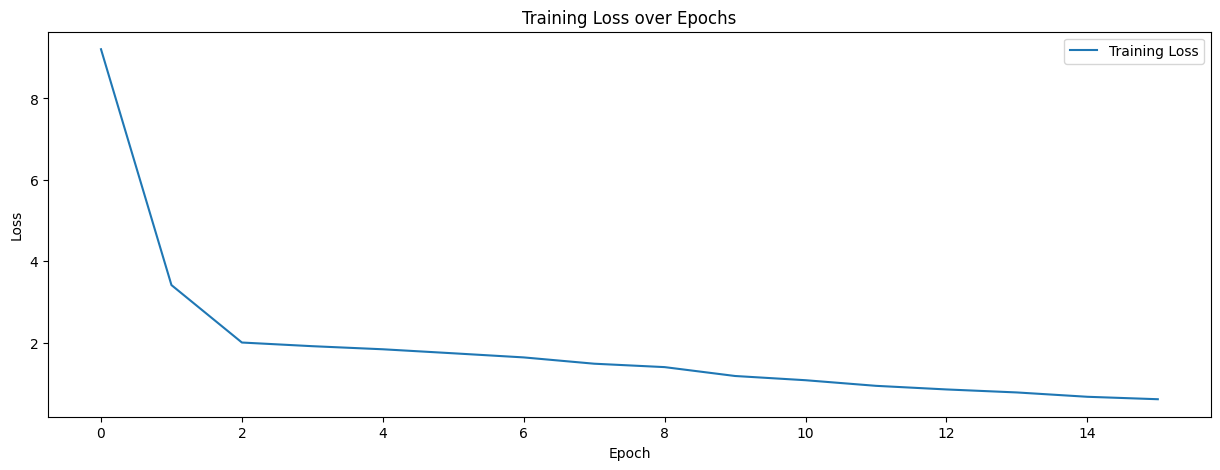

In [240]:
plt.figure(figsize=(15, 5))
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

**h)** **Implement** another MLP architecture using [`pytorch.nn.Module`](), which has the following components:
- A [linear layer](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear) with 1,200 dimensions and [relu activation](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html#torch.nn.ReLU) , which takes the encoding of one sentence pair as the input.
- A linear layer with 300 dimensions and relu activation.
- A linear layer with 300 dimensions and relu activation.
- A linear layer with 1 dimension (output layer).

In [241]:
class MLP_2(nn.Module):
  def __init__(self):
    super(MLP_2, self).__init__()
    # LAYER 1 (Input Layer)
    self.layer_1 = nn.Linear(600, 1200)
    self.relu_layer_1 = nn.ReLU()
    # self.dropout_layer_1 = nn.Dropout(0.2)

    # LAYER 2 (Hidden Layer)
    self.layer_2 = nn.Linear(1200, 300)
    self.relu_layer_2 = nn.ReLU()
    # self.dropout_layer_2 = nn.Dropout(0.2)

    # LAYER 3 (Hidden Layer)
    self.layer_3= nn.Linear(300, 300)
    self.relu_layer_3 = nn.ReLU()
    # self.dropout_layer_3 = nn.Dropout(0.2)

    # OUTPUT LAYER
    self.output_layer = nn.Linear(300, 1)

  def forward(self, x):
    # TODO: YOUR CODE HERE
    x = self.layer_1(x)
    x = self.relu_layer_1(x)
    # x = self.dropout_layer_1(x)

    x = self.layer_2(x)
    x = self.relu_layer_2(x)
    # x = self.dropout_layer_2(x)

    x = self.layer_3(x)
    x = self.relu_layer_3(x)
    # x = self.dropout_layer_3(x)

    x = self.output_layer(x)

    return x


**i)** **Initialize and train** the new class with the function from above

In [242]:
# TODO: YOUR CODE HERE
model2 = MLP_2()
print(model2)
model2 = model2.to("cuda")
optimizer = torch.optim.AdamW(model2.parameters(), lr = lr)
train_losses_second_model, model2 = train(model2, train_dataloader, dev_dataloader, optimizer, loss_function, epochs, device=device)


MLP_2(
  (layer_1): Linear(in_features=600, out_features=1200, bias=True)
  (relu_layer_1): ReLU()
  (layer_2): Linear(in_features=1200, out_features=300, bias=True)
  (relu_layer_2): ReLU()
  (layer_3): Linear(in_features=300, out_features=300, bias=True)
  (relu_layer_3): ReLU()
  (output_layer): Linear(in_features=300, out_features=1, bias=True)
)

inital train loss: 9.375911818610298

 Epoch 1 train loss: 2.8990190108617147

 Epoch 2 train loss: 1.960336931546529

 Epoch 3 train loss: 1.8576006571451822

 Epoch 4 train loss: 1.73970115714603

 Epoch 5 train loss: 1.5951750569873386

 Epoch 6 train loss: 1.4455084244410197

 Epoch 7 train loss: 1.2893674559063382

 Epoch 8 train loss: 1.0706761121749877

 Epoch 9 train loss: 0.9218517131275601

 Epoch 10 train loss: 0.7695131738980611

 Epoch 11 train loss: 0.7235391332043541

 Epoch 12 train loss: 0.5479873392317031

 Epoch 13 train loss: 0.4272974133491516

 Epoch 14 train loss: 0.33004485070705414

 Epoch 15 train loss: 0.2735815

**j)** **Plot** the loss curve both the first and the second model (you can reuse your code from above)

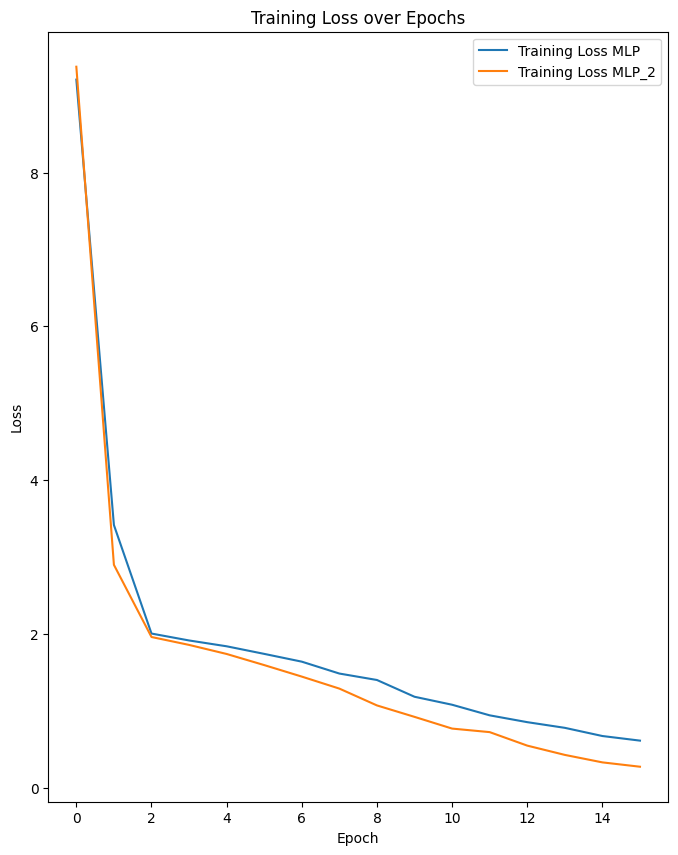

In [243]:
plt.figure(figsize=(8, 10))
plt.plot(train_losses, label='Training Loss MLP')
plt.plot(train_losses_second_model, label='Training Loss MLP_2')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

**k)** **Compare** the difference in the architectures and their corresponding losses. Describe what might have caused these changes.

##Differences in the architectures summarized:
###1. Dropout Layers: MLP uses dropout layers, while MLP_2 does not.
###2. Layer Sizes: MLP_2 has a larger first layer compared to MLP.


The increased capacity of MLP_2 due to a larger input layer may be compensating for dropout's absence, leading to somewhat similar performance as MLP. In any case, MLP_2 converges more.